In [1]:
%matplotlib notebook

import pyn.advanced_command as m

Bonjour,

Je voulais prendre quelques minutes pour vous présenter ceci. J'espère pouvoir en discuter de vive voix avec Nicolas à la rentrée... mais en attendant, je voulais un petit support, le voilà. De votre réponse dépendra les limites à imposer à la dynamique du `PFCP`, pour chacun des axes.

## Introduction

Entre l'`UPMV` (la navigation) et le `PFCP` (le contrôle) transitent des commandes de haut niveau: Psi, Vz, IAS, etc. et je reste convaincu que c'est la meilleure façon de procéder :

* parce que cela permet un bon niveau d'abstraction et cela facilite l'introduction de limitations côté PFCP qui sécurisent la partie contrôle.
* parce que piloter des ordres de plus bas niveau pose d'autres problèmes, avec des boucles de feeback en oignon (d'autant plus génantes que les deux logiciels tournent ici sur des plateformes différentes)

Ce choix fait cependant apparaître un paradoxe alors que je cherchais à suivre des trajectoires suffisamment précises pour respecter nos contraintes (corridors, etc.). Je vais essayer d'en exposer les tenants et les aboutissants, puisque que ce problème pourrait se poser dans tout autre système basé sur des ordres de haut niveau.

## La boucle complète

![loop upmv + pfcp](img/full_loop.png)

Je prendrais ici quelques hypothèses quant à la composition et l'organisation de votre système, si elles s'avères légèrement fausses, veuillez m'en excuser, les conclusions devraient cependant rester valides.

Par exemple, je suppose que $X_{ref}$, $\dot X_{ref}$ et, éventuellement, $\ddot X_{ref}$ sont présents à l'entrée du feedforward.

## Gestion des limitations
Je suppose également que les limitations agréées entre nous sont appliquées au niveau d'un générateur de trajectoire. Et l'hypothèse est faite qu'il s'agit d'un filtre d'ordre 2 du genre décrit ci-dessous, muni d'une saturation avant $\ddot X_{ref}$ et d'une autre avant $\dot X_{ref}$ :

![saturated filter](img/second_order_trajectory.png)

Voici une illustration de ce type de filtre (avec `Xref filtered` la réponse du filtre classique du second ordre et `Xref saturated` la réponse du même filtre avec les saturations activées).

<IPython.core.display.Javascript object>


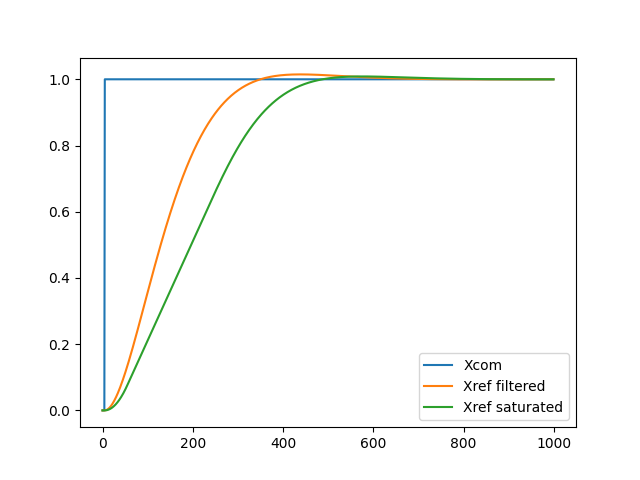

interactive(children=(FloatSlider(value=0.8, description='epsilon', max=2.0, min=0.2), FloatSlider(value=12.0,…

In [2]:
m.saturated_filter_demo()

## Filtrage des trajectoires

Même dans le cas ou l'`UPMV` générerait une commande qui respecte parfaitement les limites agréées (en utilisant par exemple le même type de filtre), on constate qu'un retard non négligeable est introduit entre `Xcom` et `Xref`.

Dans l'example qui suit, les paramètres du générateur de trajectoire du `PCFP` ont été figés sur `epsilon = 0.8`, `omega0 = 10.0`, `sat1 = 3.0` et `sat2 = 60.0`. Les paramètres de l'UPMV sont initialisé sous ces même conditions mais sont ajustables.

L'erreur de commande, celle qui doit être rattrappée par le feedback de l'`UPMV` correspond à l'aire entre les deux courbes. On peut aisément constater que même en réduisant la dynamique de `Xcom` cette erreur change peu et reste importante.

La raison principale de ce phénomène est que le générateur de trajectoire n'a aucune connaissance du fait que la commande n'est pas en régime établi (avec une dérivée nulle) mais est en fait en pleine transition.

En pointillé, on peut voir les trajectoire que l'on obtiendrai si au point courant, le régime établit était atteint. Et on peut voir que la réponse $X_ref$ avant ce point est exactement supperposable à la réponse complète du filtre.

<IPython.core.display.Javascript object>


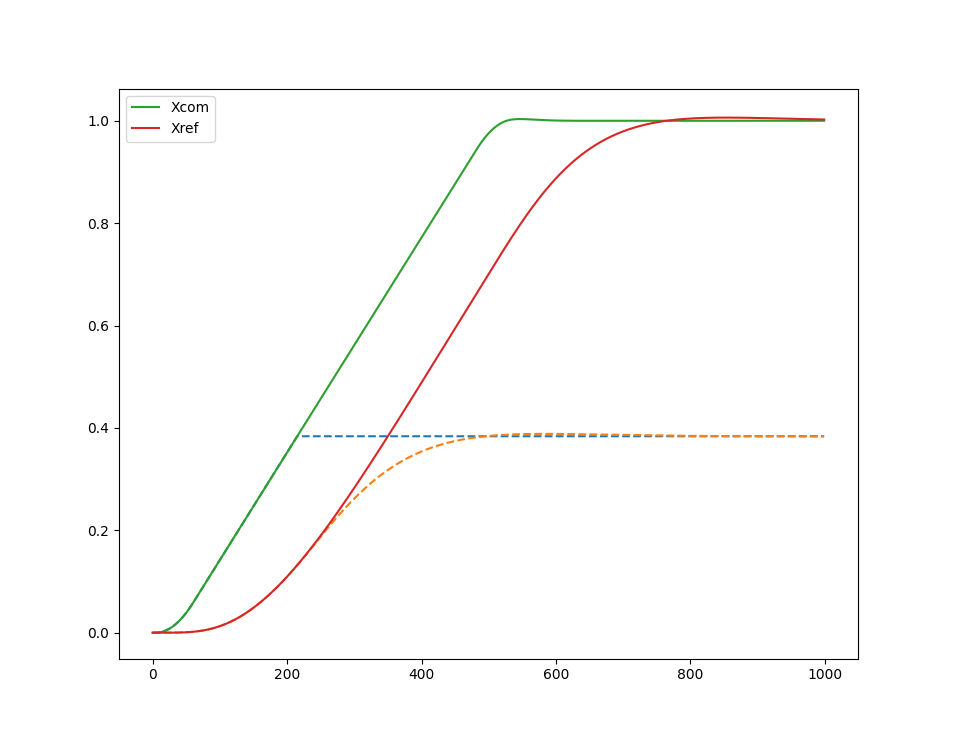

interactive(children=(FloatSlider(value=0.8, description='epsilon', max=2.0, min=0.2), FloatSlider(value=12.0,…

In [3]:
m.successive_filter_demo()

## Le paradoxe

Alors que je faisais des essais, j'ai modifié mes ordres envoyés au PFCP afin de prendre encore plus de marge vis-à-vis des limites agréées, mais comme vous avez pu le constater en jouant avec les sliders ci-dessus, cela n'a que peu d'impact sur l'aire totale entre les deux courbes. Dans le cas du Psi, cette aire représentant l'erreur de trajectoire au sein du corridor (sans tenir compte du feedback).

Le paradoxe est le suivant:

* quelle que soit la dynamique, on peut toujours trouver une trajectoire qui respecte les limites agréées et qui reste dans le corridor (au prix, éventullement, d'une vitesse de déplacement plus faible)
* encore mieux ! plus la dynamique est faible plus j'ai l'assurance que l'erreur entre `Xref` et `Xmes` sera faible (puisque la dynamique de l'hélicoptère reste la même, plus les commandes seront limitées, plus le système sera en mesure de les respecter)
* mais plus le retard imposé le générateur de trajectoire du `PFCP` augmente (et moins il reste de marge pour le corriger avec le feedback de l'`UPMV`)

Alors que la partie contrôle est de plus en plus précise avec la baisse de dynamique, la partie navigation l'est de moins en moins.

## Quelques possibilités

Les propositions les plus intéressantes tournent toutes autour du même principe : s'assurer que, d'une façon ou d'une autre, soit pris en compte le fait que la commande n'est pas en régime établi.

La pire solution serait de revenir à des ordres de plus bas niveau: Phi plutôt que Psi, Theta plutôt que Vx ou Ias. Je pense que ça apporterait d'autres problèmes tout aussi sensibles.

La solutions idéale serait, pour moi, de modifier votre générateur de trajectoire pour qu'il accepte de prendre en entrée $X_{com}$ et $\dot{X_{com}}$. Ceci suffirait à faire disparaître ce retard de boucle. _(Personnelement c'est ce que j'utilise, un générateur de trajectoire qui accèpte les dérivées et offre tout de même des limitations sur $\dot X_{ref}$ et $\ddot X_{ref}$)_

Une autre solution, qui pourrait être un intermédiaire de test, consisterait à brancher les commandes provenant de l'`UPMV` en entrée du feedforward directement (avec une éventuelle limitations simple sur les commandes et leurs dérivées)